In [1]:
#### PELLET SORTER SCRIPT
## Imports
import numpy as np
import math
from math import fabs, pi
import matplotlib.pyplot as plt
import ikpy.chain
import ikpy.link
import ikpy.utils.plot as plot_utils
from ikpy.chain import Chain
from ikpy.link import OriginLink, URDFLink
import serial
from dataclasses import dataclass
import time




### Pellet sorter functions
## Inverse kinematics
def pol2car(rho, phi):
    """
    Converts polar coordinates to cartesian

    :param rho: Float radius, modulus
    :param phi: Float argument, angle
    :return: Returns a list [x, y] of cartesian coordinates
    """

    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return[x, y]

def angle_to_pipi(input_angle):
    """
    Converts input angle to one in range [-pi, pi]

    :param input_angle: Float angle, any Real number
    :return: Returns a float angle in range [-pi, pi]
    """

    # revolutions = int((input_angle + np.sign(input_angle) * pi) / (2 * pi))
    p1 = truncated_remainder(input_angle + np.sign(input_angle) * pi, 2 * pi)
    p2 = (np.sign(np.sign(input_angle)
                  + 2 * (np.sign(fabs((truncated_remainder(input_angle + pi, 2 * pi))
                                      / (2 * pi))) - 1))) * pi
    output_angle = p1 - p2
    return output_angle #, revolutions

def angles_to_pipi(angles):
    """
    Converts list of angles to range [-pi, pi]

    :param input_angle: List of float angles
    :return: Returns a list of float angles in range [-pi, pi]
    """

    return list(map(angle_to_pipi, angles))

def truncated_remainder(dividend, divisor):
    """
    Gives truncated remainder of a division

    :param dividend: Float dividend
    :param divisor: Float divisor
    :return: Returns a float of the truncated remainder
    """
    divided_number = dividend / divisor
    divided_number = \
        -int(-divided_number) if divided_number < 0 else int(divided_number)
    remainder = dividend - divisor * divided_number
    return remainder

def sorter_chain_update(sorter_parameters):
    """
    Creates an IKPy Chain instance using the input parameters for the pellet sorter robot.
    Note that it currently ignores bounds in second joint

    :param sorter_parameters: Dictionary containing for every motor:
        Float/Int number of steps in a full revolution of the stepper motor
        Float gear ratio of the corresponding gear box
        Float length of the arm being rotated by the motor
        Float bound angle in radians such that the arm can only rotate within +-bound
        List [x, y] of floats of current cartesian coordinates of the end of the corresponding arm
        In the format: [{'steps_in_rotation':0,'gear_ratio':0,'length_mm':0,'bound_rad':0, 'cartesian':[0,0]} for k in range(n_joints)]
    :return: Returns the Chain instance for the sroter
    """
    sorter_chain = Chain(name='sorter', links=[
    OriginLink(),
    URDFLink(
        name="Base",
        bounds=(-sorter_parameters[0].get('bound_rad'),sorter_parameters[0].get('bound_rad')),
        origin_translation=[0, 0, 0],
        origin_orientation=[0, 0, 0],
        rotation=[0, 0, 1],
    ),
    URDFLink(
        name="Elbow",
        # bounds=(-sorter_parameters[1].get('bound_rad'),sorter_parameters[1].get('bound_rad')),
        origin_translation=sorter_parameters[0].get('cartesian')+[0],
        origin_orientation=[0, 0, 1],
        rotation=[0, 0, 1],
    ),
    URDFLink(
        name="Tip",
        origin_translation=sorter_parameters[1].get('cartesian')+[0],
        origin_orientation=[0, 0, 1],
        rotation=[0, 0, 0],
    ),
    ])
    return sorter_chain

def IK_difference(cartesian_target, cartesian_initial):
    """
    Gives the angle difference in radians of each joint for the poses corresponding to the initial and target tip coordinates for the pellet sorter robot

    :param cartesian_target: List [x, y] of floats corresponding to the target cartesian coordinates of the tip of the pellet sorter robot
    :param cartesian_initial: List [x, y] of floats corresponding to the initial cartesian coordinates of the tip of the pellet sorter robot
    :return: List of floats of the angle difference for each joint, in radians
    """

    global sorter_chain
    joint_target = sorter_chain.inverse_kinematics(cartesian_target+[0])
    joint_initial = sorter_chain.inverse_kinematics(cartesian_initial+[0])
    return angles_to_pipi(joint_target[1:3]-joint_initial[1:3])

def rad2steps(theta, steps_in_rotation):
    """
    Converts angle in radians to the number of steps the motor needs to take to rotate by that angle

    :param theta: Float angle in radians
    :param steps_in_rotation: Float/int number of steps in a full revolution of the stepper motor
    :return: Int number of steps corresponding to the angle and motor
    """

    return (np.rint(theta*steps_in_rotation/(2*math.pi))).astype(int)

def IK_steps(cartesian_target, cartesian_initial):
    """
    Gives number of steps each stepper motor must take to go from initial to target tip coordinates in the pellet sorter robot

    :param cartesian_target: List [x, y] of floats corresponding to the target cartesian coordinates of the tip of the pellet sorter robot
    :param cartesian_initial: List [x, y] of floats corresponding to the initial cartesian coordinates of the tip of the pellet sorter robot
    :return: List [n1, n2] of int of the number of steps each stepper motor must take for the pellet sorter robot to go from initial to target tip coordinates
    """

    global sorter_parameters
    angle_difference = IK_difference(cartesian_target, cartesian_initial)
    steps = [0]*len(sorter_parameters)
    for n in range(len(sorter_parameters)):
        steps[n] = rad2steps(sorter_parameters[n].get('gear_ratio')*angle_difference[n], sorter_parameters[n].get('steps_in_rotation'))
    return steps

def IK_plot(cartesian_target, cartesian_initial):
    """
    Plots the initial and target poses of the pellet sorter robot, given the tip coordinates, on the same plot

    :param cartesian_target: List [x, y] of floats corresponding to the target cartesian coordinates of the tip of the pellet sorter robot
    :param cartesian_initial: List [x, y] of floats corresponding to the initial cartesian coordinates of the tip of the pellet sorter robot
    """

    # %matplotlib inline
    fig, ax = plot_utils.init_3d_figure()
    ax.set_zlim(0, 1)
    renamed_sorter_chain = sorter_chain
    renamed_sorter_chain.name = 'Target'
    renamed_sorter_chain.plot(sorter_chain.inverse_kinematics(cartesian_target+[0]), ax)
    renamed_sorter_chain.name = 'Initial'
    renamed_sorter_chain.plot(sorter_chain.inverse_kinematics(cartesian_initial+[0]), ax)
    max_length = sum([sorter_parameters[n].get('length_mm') for n in range(len(sorter_parameters))])
    plt.xlim(-max_length, max_length)
    plt.ylim(-max_length, max_length)
    plt.legend()



## Serial communications
def runSteps(steps):
    """
    Takes array of two ints, corresponding to number of steps for base and elbow motors, and requests to Arduino through serial
    The message is 10 chars: sddddsdddd where s is sign (0 or -) and d are the digits. Positive means CCW from top view if wired accordingly.

    :param steps: List [n1, n2] of int corresponding to the number of steps each stepper motor must take
    """ 

    number_len = 5
    message = str(steps[0]).zfill(number_len) + str(steps[1]).zfill(number_len)
    arduino.write(message.encode("utf-8"))

def goToCartesianFrom(cartesian_target, cartesian_initial):
    """
    Requests Arduino through serial to run necessary steps for pellet sorter robot cartesian tip coordinates to go from initial to target

    :param cartesian_target: List [x, y] of floats corresponding to the target cartesian coordinates of the tip of the pellet sorter robot
    :param cartesian_initial: List [x, y] of floats corresponding to the initial cartesian coordinates of the tip of the pellet sorter robot
    """

    runSteps(IK_steps(cartesian_target, cartesian_initial))

def runValve(state):
    """
    Requests Arduino through serial to open or close pellet sorter robot valve

    :param state: Bool, true for open valve and false for close valve
    """

    message = 'v'+str(int(state))
    arduino.write(message.encode("utf-8"))

def waitForSerialStr(string):
    """
    Reads Arduino serial until input string is found

    :param string: Str, line to wait for until read in Arduino serial, should not be terminated by any special charachers 
    """

    arduino.reset_input_buffer()
    waiting = True
    while waiting:
        line = arduino.readline()   # read a '\n' terminated line
        if line:
            decoded_line = line.decode().strip()
            print(decoded_line)
            if decoded_line == string:
                waiting = False

def waitUntilWeight(number):
    """
    Reads Balance serial until stable weight larger than input number is found
    Note that the 'ASNG/W+ ' term might need to be changed depending of what mode balance operates in; monitor serial to find out (Eg: Net weight would be 'ASNN/W+ ')

    :param number: Float in kg to be surpassed by Balance reading
    """

    balance.reset_input_buffer()
    waiting = True
    while waiting:
        line = balance.readline()   # read a '\n' terminated line
        if line:
            decoded_line = line.decode('ascii').strip()
            print(decoded_line)
            if decoded_line[0:8]=="ASNG/W+ " and decoded_line[13:17]=="  kg" and decoded_line[8:13].replace(".", "").isnumeric() and float(decoded_line[8:13]) >= number:
                waiting = False

def tareBalance():
    """
    Requests Balance through serial to tare/zero its current reported weight
    """

    balance.write("Z\r\n".encode("ascii"))




### Tray class definitions
## Cup
@dataclass
class Cup:
    cup_id: str
    capacity_kg: float
    material: str = None
    fill_kg: float = 0
    ## TODO: implement contents method to redefine, assume completely full unless float given

## Slot
@dataclass
class Slot:
    cartesian: list # Measured from center of tray to center of slots
    cup: Cup = None

    def add_cup(self, cup):
        if self.cup is not None:
            print(f"Slot is already occupied.")
        else:
            self.cup = cup

    def remove_cup(self):
        if self.cup is not None:
            self.cup = None
        else:
            print(f"No cup found in slot.")
    
    def take_cup(self):
        if self.cup is not None:
            taken_cup = self.cup
            self.cup = None
            return taken_cup
        else:
            print(f"No cup found in slot.")
            return None
        
    def set_cup_material(self, material):
        if self.cup is not None:
            self.cup.material = material
        else:
            print(f"No cup found in slot.")

## Tray
@dataclass
class Tray:
    tray_id: str
    cartesian: list # Measured from axis of rotation of top joint to center of tray
    slots: list

    def add_cup(self, cup, slot_number):
        self.slots[slot_number].add_cup(cup)

    def remove_cup(self, slot_number):
        self.slots[slot_number].remove_cup()

    def take_cup(self, slot_number):
        return self.slots[slot_number].take_cup()

    def get_slot_cartesian(self, slot_number):
        return list(np.array(self.slots[slot_number].cartesian) + np.array(self.cartesian))
    
    def fill_all_slots_ez(self, first_cup_id, cup_capacity_kg):
        [self.slots[i].add_cup(Cup(cup_id=(first_cup_id + i), capacity_kg=cup_capacity_kg)) for i in range(len(self.slots))]

    def slots_occupied(self):
        return [slot.cup is not None for slot in self.slots]

    def set_all_material(self, material):
        for i in range(len(self.slots)):
            if self.slots_occupied()[i]:
                self.slots[i].set_cup_material(material)

## Tray Manager
class TrayManager:
    def __init__(self):
        self.trays = []

    def add_tray(self, tray):
        self.trays.append(tray)

    def remove_tray(self, tray):
        self.trays.remove(tray)

    def add_cup_data(self, cup):
        self.cups_data[cup.cup_id] = cup
   
    ## TODO: Implement way of fettching a cup by ID, eg: for tray in trays > for slot in slots > compare IDs, get




### Script definition
def fill_tray(tray, cartesian_initial):
    # Assumes valve starts closed
    cartesian_prev = cartesian_initial
    global sorter_parameters
    global sorter_chain

    # Bound is overridden for Inverse Kinematics to prioritize bottom joint over top joint rotation
    bound_rad_initial = sorter_parameters[0]['bound_rad']
    sorter_parameters[0]['bound_rad'] = np.deg2rad(0.1)

    sorter_chain = sorter_chain_update(sorter_parameters)
    for slot_number in range(len(tray.slots)):
        if tray.slots_occupied()[slot_number]:  # TODO: Add check for cup not being full & matching materials
            tareBalance()

            if slot_number == 8:
                sorter_parameters[0]['bound_rad'] = bound_rad_initial
                sorter_chain = sorter_chain_update(sorter_parameters)
            
            IK_plot(tray.get_slot_cartesian(slot_number), cartesian_prev)
            goToCartesianFrom(tray.get_slot_cartesian(slot_number), cartesian_prev)
            waitForSerialStr("pos finished")
            runValve(True)
            waitForSerialStr("val finished")
            # print('Waiting for Balance')
            waitUntilWeight(tray.slots[slot_number].cup.capacity_kg)
            runValve(False)
            waitForSerialStr("val finished")
            cartesian_prev = tray.get_slot_cartesian(slot_number)
    
    IK_plot(cartesian_initial, cartesian_prev)
    goToCartesianFrom(cartesian_initial, cartesian_prev)
    waitForSerialStr("pos finished")


def fill_tray_SIMULATED(tray, cartesian_initial):
    # Assumes valve starts closed
    cartesian_prev = cartesian_initial
    global sorter_parameters
    global sorter_chain
    bound_rad_initial = sorter_parameters[0]['bound_rad']
    sorter_parameters[0]['bound_rad'] = np.deg2rad(0.1)
    sorter_chain = sorter_chain_update(sorter_parameters)
    for slot_number in range(len(tray.slots)):
        if tray.slots_occupied()[slot_number]:  # TODO: Add check for cup not being full
            if slot_number == 8:
                sorter_parameters[0]['bound_rad'] = bound_rad_initial
                sorter_chain = sorter_chain_update(sorter_parameters)
            IK_plot(tray.get_slot_cartesian(slot_number), cartesian_prev)
            cartesian_prev = tray.get_slot_cartesian(slot_number)
    IK_plot(cartesian_initial, cartesian_prev)




### Initializations
# sorter_chain, sorter_parameters and arduino should be global variables

n_joints = 2
sorter_parameters = [{'steps_in_rotation':0,'gear_ratio':0,'length_mm':0,'bound_rad':0, 'cartesian':[0,0]} for k in range(n_joints)]
## Top
sorter_parameters[0]['steps_in_rotation'] = np.round(200*1.1)   # Calibrate multiplicative factor to compensate lost steps if necessary
sorter_parameters[0]['gear_ratio'] = 6
sorter_parameters[0]['length_mm'] = 180.5
sorter_parameters[0]['bound_rad'] = np.deg2rad(35)    # np.deg2rad(35)  # IK Rotation bound in either direction, not total
sorter_parameters[0]['cartesian'] = [sorter_parameters[0].get('length_mm'), 0]
## Bot
sorter_parameters[1]['steps_in_rotation'] = 812
sorter_parameters[1]['gear_ratio'] = 2.4
sorter_parameters[1]['length_mm'] = np.sqrt(32.7**2 + 79.2**2)  # 84.4
sorter_parameters[1]['bound_rad'] = np.deg2rad(10*360)
sorter_parameters[1]['cartesian'] = [sorter_parameters[1].get('length_mm'), 0]


sorter_chain = sorter_chain_update(sorter_parameters)

tray_1 = Tray('1', [sorter_parameters[0]['length_mm'], 0], [
    Slot([79.2,32.7]),
    Slot([32.7,79.2]),
    Slot([-32.7,79.2]),
    Slot([-79.2,32.7]),
    Slot([-79.2,-32.7]),
    Slot([-32.7,-79.2]),
    Slot([32.7,-79.2]),
    Slot([79.2,-32.7]),
    Slot([0,0]), 
    ])

tray_1.fill_all_slots_ez(0, 0.160)  # Adjust cup capacity in kg here

tray_1.set_all_material('PLA####')

c:\Users\jorge.ilarraza\AppData\Local\anaconda3\lib\site-packages\ikpy\chain.py:60: UserWarning: Link Base link (index: 0) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive
  warnings.warn("Link {} (index: {}) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive".format(link.name, link_index))


In [4]:
### Serial initialization
## Arduino
arduino = serial.Serial('COM7', 9600)

In [5]:
## Balance
balance = serial.Serial('COM8', 9600)

pos finished
Opening valve
val finished
Waiting for Balance
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG/W+ 0.000  kg
ASNG

SerialException: ClearCommError failed (PermissionError(13, 'Access is denied.', None, 5))

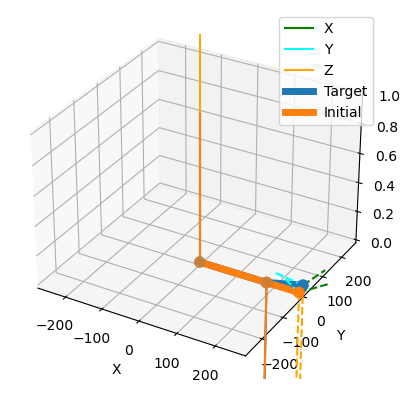

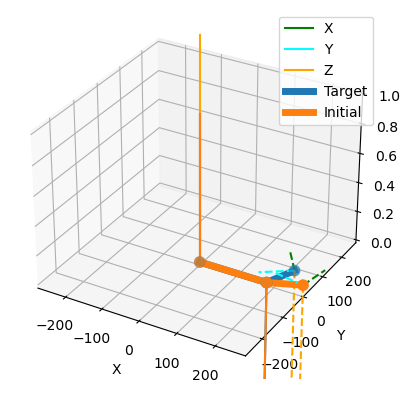

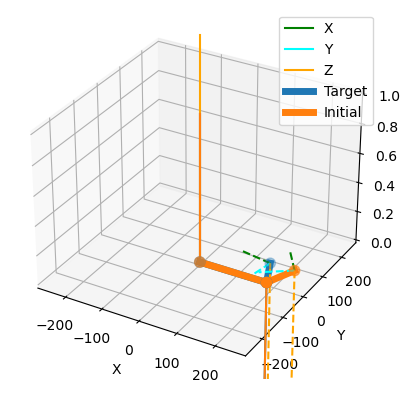

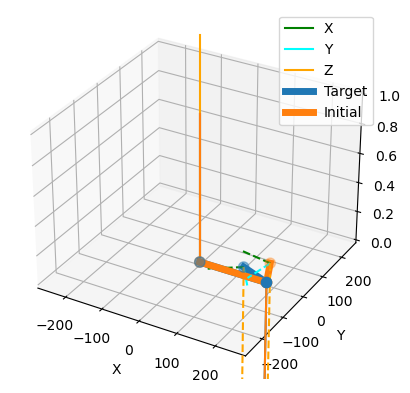

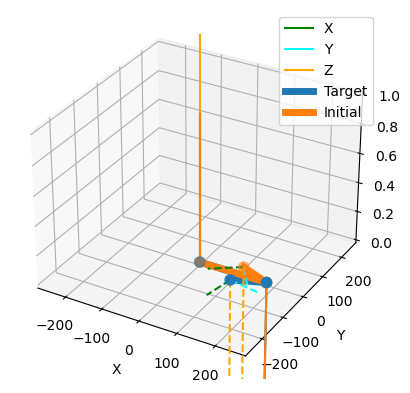

In [14]:
### MAIN SCRIPT
fill_tray(tray_1, [sum([sorter_parameters[n].get('length_mm') for n in range(len(sorter_parameters))]), 0])

### END OF SCRIPT

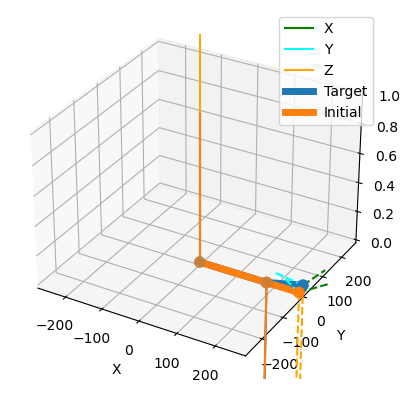

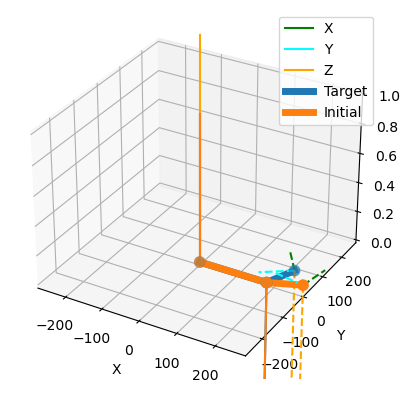

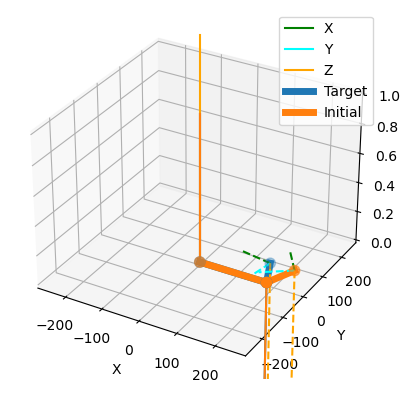

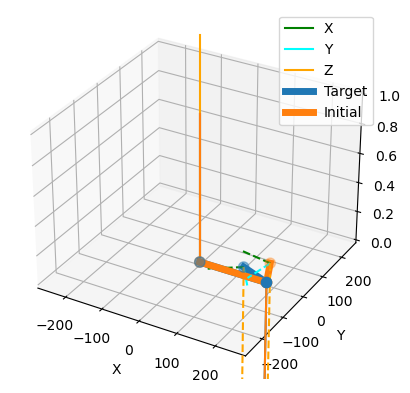

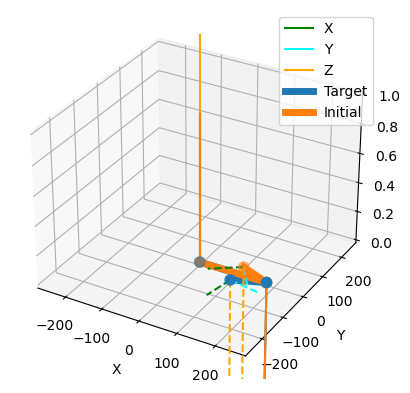

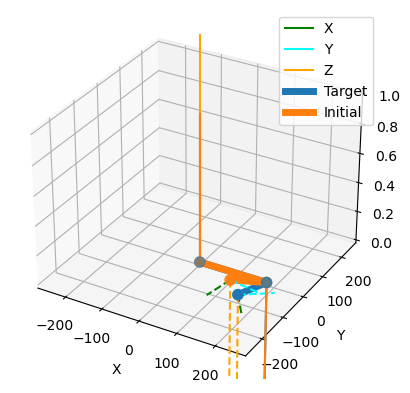

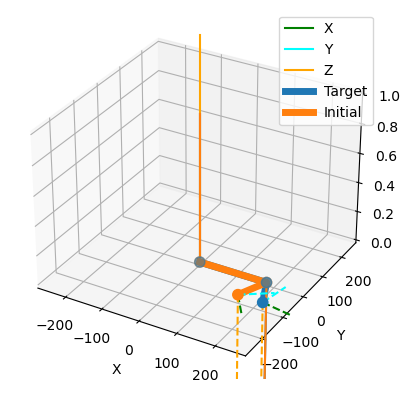

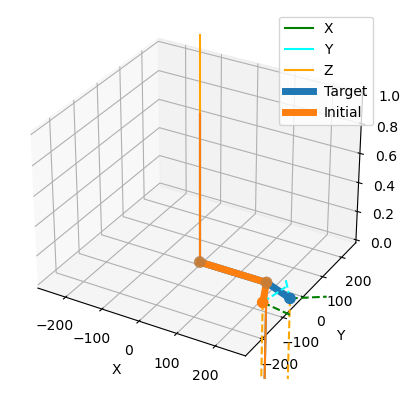

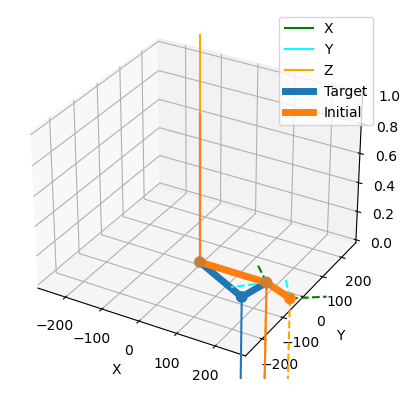

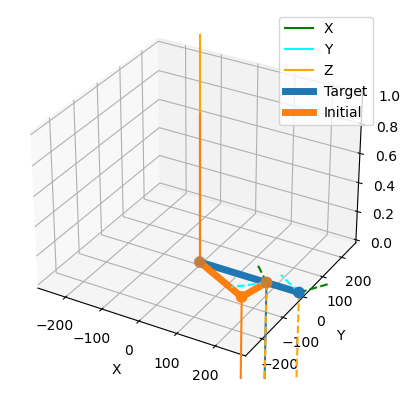

In [4]:
### TESTING

fill_tray_SIMULATED(tray_1, [sum([sorter_parameters[n].get('length_mm') for n in range(len(sorter_parameters))]), 0])

In [15]:
runSteps([0,1949])

In [22]:
runSteps([300,0])

In [31]:
goToCartesianFrom(tray_1.get_slot_cartesian(8), [sum([sorter_parameters[n].get('length_mm') for n in range(len(sorter_parameters))]), 0])


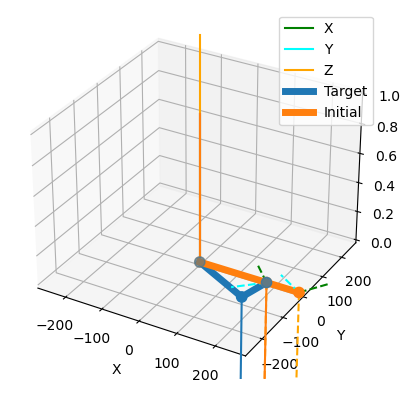

In [27]:
IK_plot(tray_1.get_slot_cartesian(8), [sum([sorter_parameters[n].get('length_mm') for n in range(len(sorter_parameters))]), 0])

In [6]:
tray_1.slots[0].cup.capacity_kg

0.14